# Assignment 1: Sampler Synthesis — Starter Code

This notebook provides baseline implementations of Random Walk Metropolis-Hastings and HMC using [BlackJAX](https://blackjax-devs.github.io/blackjax/). Use these as reference points for your novel sampler.

**Your task**: Design, implement, and analyze a novel MCMC sampler. Compare it to these baselines on the benchmark distributions.

In [32]:
import arviz as az
import blackjax
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["font.size"] = 12

---
## Benchmark Distribution: Rosenbrock (Banana)

The Rosenbrock distribution has a curved, narrow ridge that tests how well samplers handle strong correlations and curved geometry. This is challenging because:
- The high-probability region is thin and curved
- Random walk proposals often step off the ridge
- Samplers need to follow the curved geometry efficiently

In [33]:
def log_prob_rosenbrock(theta):
    """Rosenbrock (banana) distribution.

    log p(x, y) ∝ -(1-x)²/20 - (y - x²)²

    This creates a curved, banana-shaped distribution that tests
    how well samplers handle strong correlations and curved geometry.
    """
    x, y = theta[0], theta[1]
    return -0.05 * (1 - x) ** 2 - (y - x**2) ** 2

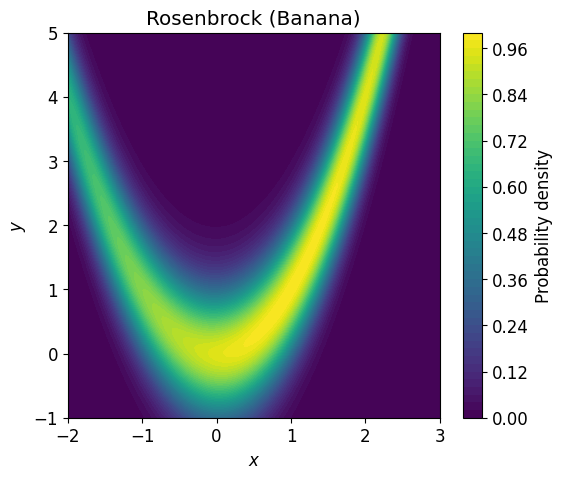

In [34]:
def plot_distribution(log_prob_fn, title, xlim=(-4, 4), ylim=(-4, 4)):
    """Visualize a 2D log probability distribution."""
    x = jnp.linspace(*xlim, 200)
    y = jnp.linspace(*ylim, 200)
    X, Y = jnp.meshgrid(x, y)
    positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)

    log_probs = jax.vmap(log_prob_fn)(positions).reshape(X.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(X, Y, jnp.exp(log_probs), levels=50, cmap="viridis")
    plt.colorbar(label="Probability density")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    plt.title(title)
    plt.show()


plot_distribution(log_prob_rosenbrock, "Rosenbrock (Banana)", xlim=(-2, 3), ylim=(-1, 5))

---
## Baseline 1: Random Walk Metropolis-Hastings

The simplest MCMC method. Proposes isotropic Gaussian steps — no gradient information.

**Tuning tip:** Target ~23-50% acceptance rate. Higher isn't better — it means steps are too small.

In [35]:
def run_rwmh(key, log_prob_fn, initial_position, sigma, n_samples):
    """Run Random Walk Metropolis-Hastings using BlackJAX.

    Args:
        key: JAX random key
        log_prob_fn: Log probability function
        initial_position: Starting point, shape (D,)
        sigma: Proposal standard deviation (scalar or array)
        n_samples: Number of samples to draw

    Returns:
        samples: Array of shape (n_samples, D)
        acceptance_rate: Fraction of accepted proposals
    """
    # Initialize the sampler with a normal proposal distribution
    rmh = blackjax.rmh(log_prob_fn, blackjax.mcmc.random_walk.normal(sigma))
    initial_state = rmh.init(initial_position)

    # Build the sampling loop
    @jax.jit
    def one_step(state, key):
        state, info = rmh.step(key, state)
        return state, (state.position, info.is_accepted)

    # Run the chain
    keys = jr.split(key, n_samples)
    _, (samples, accepted) = jax.lax.scan(one_step, initial_state, keys)

    return samples, accepted.mean()

---
## Baseline 2: Hamiltonian Monte Carlo (HMC)

Uses gradient information to make informed proposals. Typically much more efficient than random walk.

**Tuning tip:** Target ~65-90% acceptance rate. Tune step_size first, then n_leapfrog.

In [36]:
def run_hmc(key, log_prob_fn, initial_position, step_size, n_leapfrog, n_samples):
    """Run HMC using BlackJAX.

    Args:
        key: JAX random key
        log_prob_fn: Log probability function
        initial_position: Starting point, shape (D,)
        step_size: Leapfrog step size (epsilon)
        n_leapfrog: Number of leapfrog steps per iteration
        n_samples: Number of samples to draw

    Returns:
        samples: Array of shape (n_samples, D)
        acceptance_rate: Fraction of accepted proposals
    """
    # Initialize the sampler (identity mass matrix)
    inverse_mass_matrix = jnp.ones(initial_position.shape[0])
    hmc = blackjax.hmc(
        log_prob_fn,
        step_size=step_size,
        inverse_mass_matrix=inverse_mass_matrix,
        num_integration_steps=n_leapfrog,
    )
    initial_state = hmc.init(initial_position)

    # Build the sampling loop
    @jax.jit
    def one_step(state, key):
        state, info = hmc.step(key, state)
        return state, (state.position, info.acceptance_rate)

    # Run the chain
    keys = jr.split(key, n_samples)
    _, (samples, accepted) = jax.lax.scan(one_step, initial_state, keys)

    return samples, accepted.mean()

---
## Run Baselines on Rosenbrock

In [37]:
key = jr.PRNGKey(42)
key1, key2 = jr.split(key)

initial_pos = jnp.array([0.0, 0.0])
n_samples = 50_000

# Random Walk MH
rwmh_samples, rwmh_acc = run_rwmh(key1, log_prob_rosenbrock, initial_pos, sigma=1.0, n_samples=n_samples)
print(f"RWMH acceptance rate: {rwmh_acc:.2%}")

# HMC
hmc_samples, hmc_acc = run_hmc(
    key2, log_prob_rosenbrock, initial_pos, step_size=0.2, n_leapfrog=10, n_samples=n_samples
)
print(f"HMC acceptance rate: {hmc_acc:.2%}")

RWMH acceptance rate: 50.02%
HMC acceptance rate: 74.78%


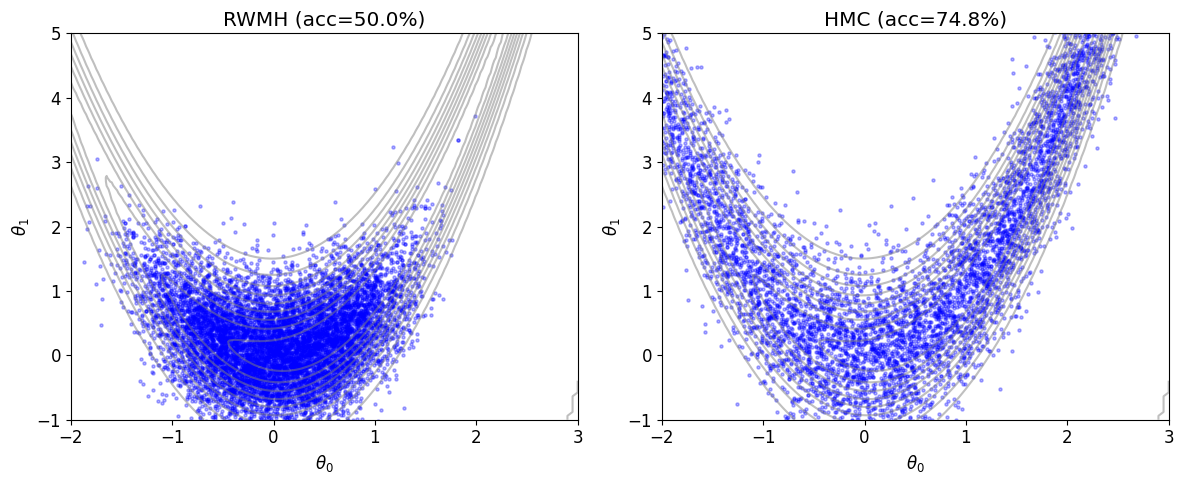

In [38]:
def plot_samples_comparison(samples1, samples2, label1, label2, log_prob_fn, xlim, ylim):
    """Plot samples from two methods side by side."""
    # Compute contours
    x = jnp.linspace(*xlim, 100)
    y = jnp.linspace(*ylim, 100)
    X, Y = jnp.meshgrid(x, y)
    positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)
    log_probs = jax.vmap(log_prob_fn)(positions).reshape(X.shape)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for ax, samples, label in zip(axes, [samples1, samples2], [label1, label2]):
        ax.contour(X, Y, jnp.exp(log_probs), levels=10, colors="gray", alpha=0.5)
        ax.scatter(samples[::5, 0], samples[::5, 1], alpha=0.3, s=5, c="blue")
        ax.set_xlabel(r"$\theta_0$")
        ax.set_ylabel(r"$\theta_1$")
        ax.set_title(label)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    plt.tight_layout()
    plt.show()


plot_samples_comparison(
    rwmh_samples,
    hmc_samples,
    f"RWMH (acc={rwmh_acc:.1%})",
    f"HMC (acc={hmc_acc:.1%})",
    log_prob_rosenbrock,
    xlim=(-2, 3),
    ylim=(-1, 5),
)

---
## Diagnostics with ArviZ

[ArviZ](https://python.arviz.org/) provides standard MCMC diagnostics. Key metrics:
- **Acceptance rate**: Too low = proposals too aggressive; too high = proposals too timid
- **Effective Sample Size (ESS)**: How many independent samples you effectively have
- **Trace plots**: Visual check for mixing and stationarity
- **Autocorrelation**: How correlated successive samples are

In [39]:
def samples_to_inference_data(samples, var_names=None):
    """Convert samples array to ArviZ InferenceData.

    Args:
        samples: Array of shape (n_samples, n_dims)
        var_names: Optional list of variable names

    Returns:
        ArviZ InferenceData object
    """
    if var_names is None:
        var_names = [f"theta_{i}" for i in range(samples.shape[1])]

    # ArviZ expects dict of {var_name: array} with shape (n_chains, n_samples)
    data_dict = {name: samples[None, :, i] for i, name in enumerate(var_names)}
    return az.convert_to_inference_data(data_dict)


def summarize_sampler(samples, name, var_names=None):
    """Print summary statistics for samples using ArviZ."""
    idata = samples_to_inference_data(samples, var_names)
    print(f"\n=== {name} ===")
    display(az.summary(idata, kind="stats"))

In [40]:
# Rosenbrock diagnostics
var_names = ["x", "y"]

rwmh_idata = samples_to_inference_data(rwmh_samples, var_names)
hmc_idata = samples_to_inference_data(hmc_samples, var_names)

# Summary statistics (mean, sd, ESS)
summarize_sampler(rwmh_samples, "RWMH — Rosenbrock", var_names)
summarize_sampler(hmc_samples, "HMC — Rosenbrock", var_names)


=== RWMH — Rosenbrock ===


,mean,sd,hdi_3%,hdi_97%
x,0.048,0.637,-1.105,1.206
y,0.266,0.659,-0.982,1.497



=== HMC — Rosenbrock ===


,mean,sd,hdi_3%,hdi_97%
x,0.456,2.202,-3.390,4.018
y,4.970,5.012,-0.379,15.324


RWMH Trace Plots:


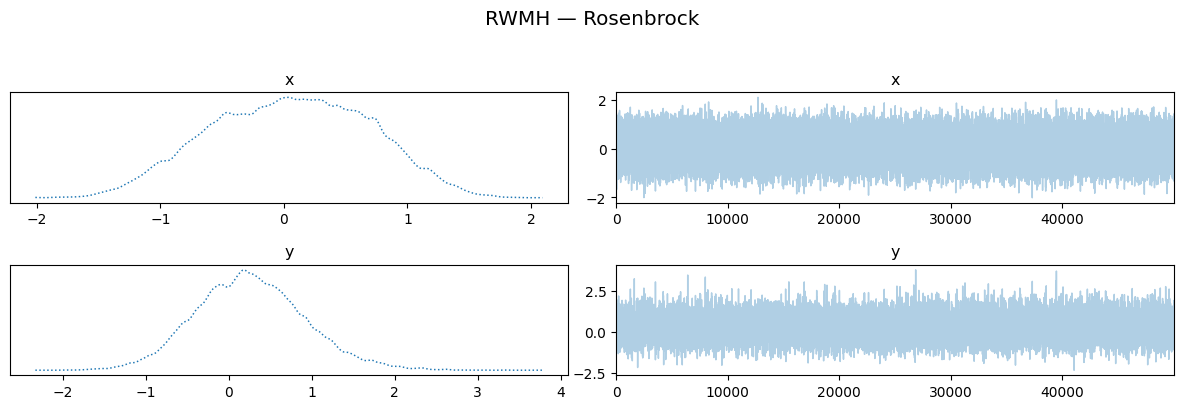


HMC Trace Plots:


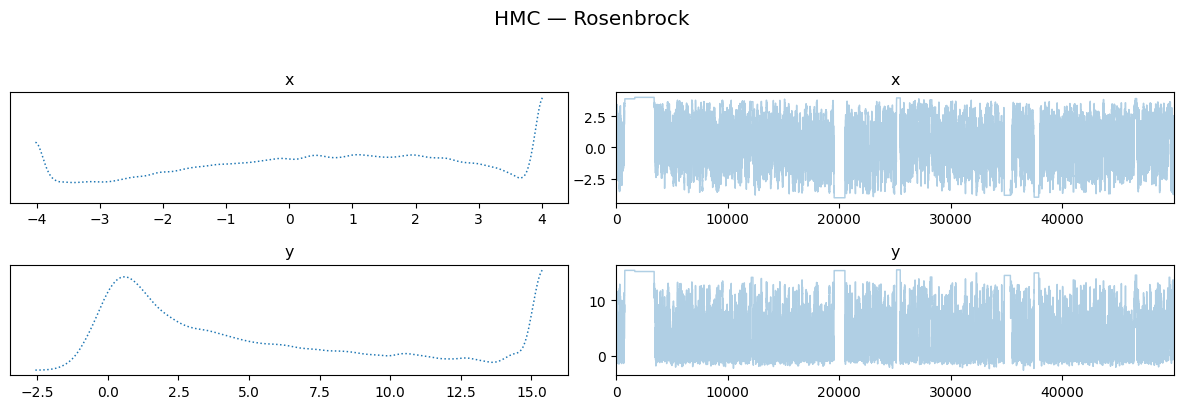

In [41]:
# Trace plots — Rosenbrock
print("RWMH Trace Plots:")
az.plot_trace(rwmh_idata, combined=True, figsize=(12, 4))
plt.suptitle("RWMH — Rosenbrock", y=1.02)
plt.tight_layout()
plt.show()

print("\nHMC Trace Plots:")
az.plot_trace(hmc_idata, combined=True, figsize=(12, 4))
plt.suptitle("HMC — Rosenbrock", y=1.02)
plt.tight_layout()
plt.show()

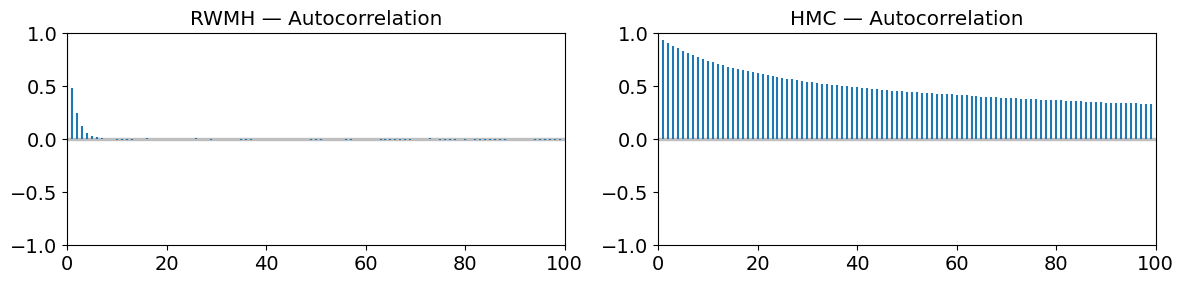

In [42]:
# Autocorrelation — Rosenbrock
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
az.plot_autocorr(rwmh_idata, ax=axes[0], combined=True)
axes[0].set_title("RWMH — Autocorrelation")
az.plot_autocorr(hmc_idata, ax=axes[1], combined=True)
axes[1].set_title("HMC — Autocorrelation")
plt.tight_layout()
plt.show()

---
## Discussion: Why Does RWMH Struggle Here?

Look carefully at the results above. You might notice something surprising: RWMH has *lower* autocorrelation than HMC, yet HMC explores the distribution much better. What's going on?

**The issue is local vs. global mixing.** RWMH with isotropic proposals faces a dilemma on curved distributions like the Rosenbrock:
- If the proposal scale is small enough to stay on the narrow ridge, it can't move far along the banana
- If the proposal scale is large enough to explore, most proposals step off the ridge and get rejected

So RWMH ends up jittering locally — samples decorrelate quickly *within* its local neighborhood, but it never traverses the full banana. Low autocorrelation doesn't mean good exploration!

**HMC uses gradients to follow the curve.** It makes long, coherent moves along the ridge without stepping off. The high autocorrelation is just because consecutive samples are along the same trajectory — but they're actually covering the full posterior.

This is exactly the kind of geometry where HMC shines, and one of the main motivations for gradient-based samplers.

---
## Benchmark Distribution 2: Neal's Funnel

Neal's Funnel is a hierarchical distribution that varies dramatically in scale across the space. The narrow "neck" of the funnel is notoriously difficult for fixed step-size samplers.

$$v \sim \mathcal{N}(0, 9), \quad x \sim \mathcal{N}(0, e^v)$$

This means:
- When $v$ is large and positive, $x$ can vary widely
- When $v$ is large and negative, $x$ is tightly constrained near 0
- A single step size can't work well everywhere

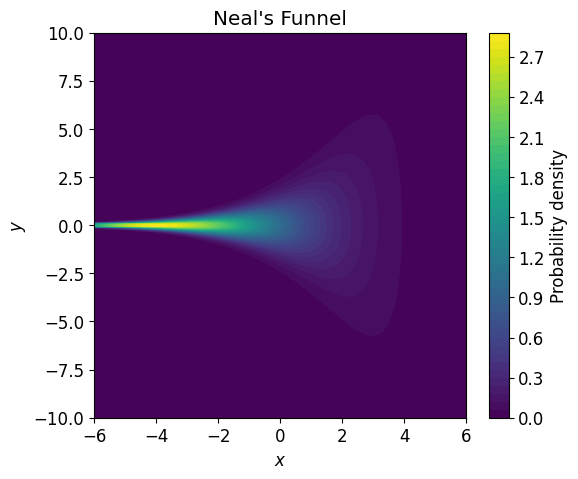

In [43]:
def log_prob_funnel(theta):
    """Neal's Funnel distribution.

    v ~ N(0, 9)
    x ~ N(0, exp(v))

    This creates a funnel shape where the scale of x depends on v.
    The narrow neck (small v) is very hard to sample.
    """
    v, x = theta[0], theta[1]
    log_p_v = -0.5 * v**2 / 9  # v ~ N(0, 9)
    log_p_x_given_v = -0.5 * x**2 * jnp.exp(-v) - 0.5 * v  # x ~ N(0, exp(v))
    return log_p_v + log_p_x_given_v


plot_distribution(log_prob_funnel, "Neal's Funnel", xlim=(-6, 6), ylim=(-10, 10))

In [44]:
# --- Run baselines on Neal's Funnel ---
# Tuning rationale: Neal's Funnel has v ~ N(0,9), so sd(v)=3. The scale of x
# varies exponentially with v, making fixed step sizes inherently suboptimal.
# We tune each baseline toward its recommended acceptance range.
key = jr.PRNGKey(123)
key1, key2 = jr.split(key)

initial_pos_funnel = jnp.array([0.0, 0.0])
n_samples = 50_000

# RWMH on Funnel — sigma=2.0 targets ~30-40% acceptance (larger steps to explore v)
rwmh_funnel_samples, rwmh_funnel_acc = run_rwmh(
    key1, log_prob_funnel, initial_pos_funnel, sigma=2.0, n_samples=n_samples
)
print(f"RWMH acceptance rate (Funnel): {rwmh_funnel_acc:.2%}")

# HMC on Funnel — step_size=0.4 achieves ~70% acceptance (within the 70-85% target range)
hmc_funnel_samples, hmc_funnel_acc = run_hmc(
    key2, log_prob_funnel, initial_pos_funnel,
    step_size=0.4, n_leapfrog=10, n_samples=n_samples
)
print(f"HMC acceptance rate (Funnel): {hmc_funnel_acc:.2%}")

RWMH acceptance rate (Funnel): 37.63%
HMC acceptance rate (Funnel): 69.98%


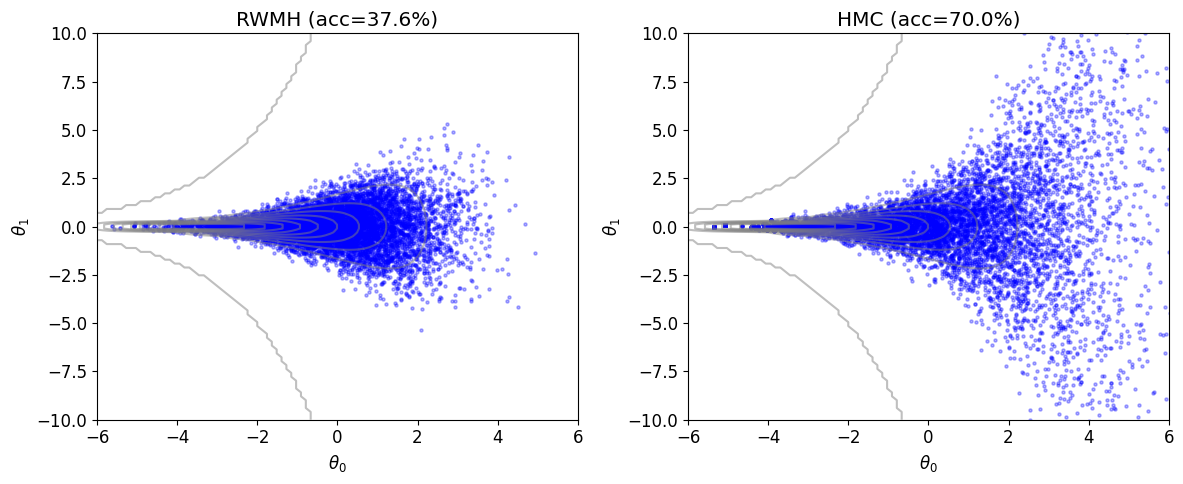

In [45]:
# Scatter plots — Neal's Funnel
plot_samples_comparison(
    rwmh_funnel_samples,
    hmc_funnel_samples,
    f"RWMH (acc={rwmh_funnel_acc:.1%})",
    f"HMC (acc={hmc_funnel_acc:.1%})",
    log_prob_funnel,
    xlim=(-6, 6),
    ylim=(-10, 10),
)

In [46]:
# Diagnostics — Neal's Funnel
var_names_funnel = ["v", "x"]

rwmh_funnel_idata = samples_to_inference_data(rwmh_funnel_samples, var_names_funnel)
hmc_funnel_idata = samples_to_inference_data(hmc_funnel_samples, var_names_funnel)

summarize_sampler(rwmh_funnel_samples, "RWMH — Neal's Funnel", var_names_funnel)
summarize_sampler(hmc_funnel_samples, "HMC — Neal's Funnel", var_names_funnel)


=== RWMH — Neal's Funnel ===


,mean,sd,hdi_3%,hdi_97%
v,-0.330,1.538,-3.263,2.441
x,-0.004,0.966,-2.031,1.869



=== HMC — Neal's Funnel ===


,mean,sd,hdi_3%,hdi_97%
v,-0.153,2.958,-5.344,4.548
x,-0.281,6.769,-7.191,8.072


RWMH Trace Plots:


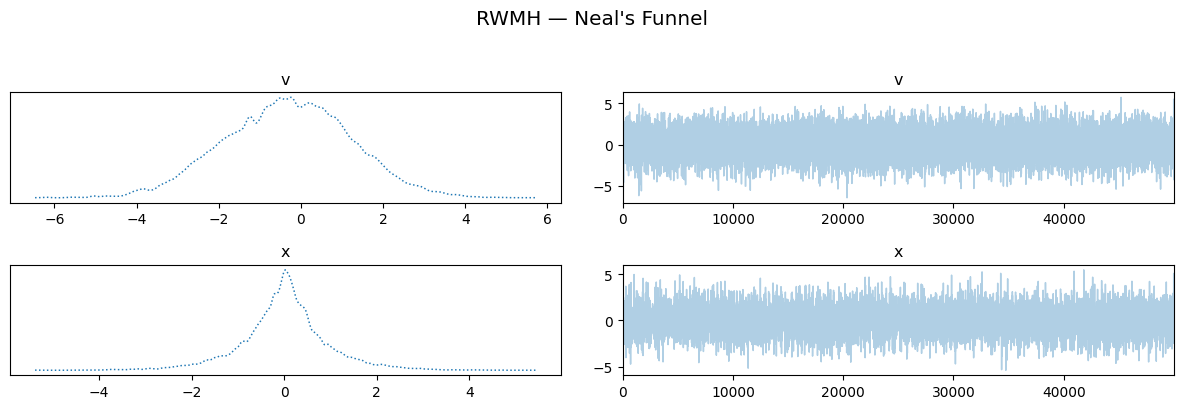


HMC Trace Plots:


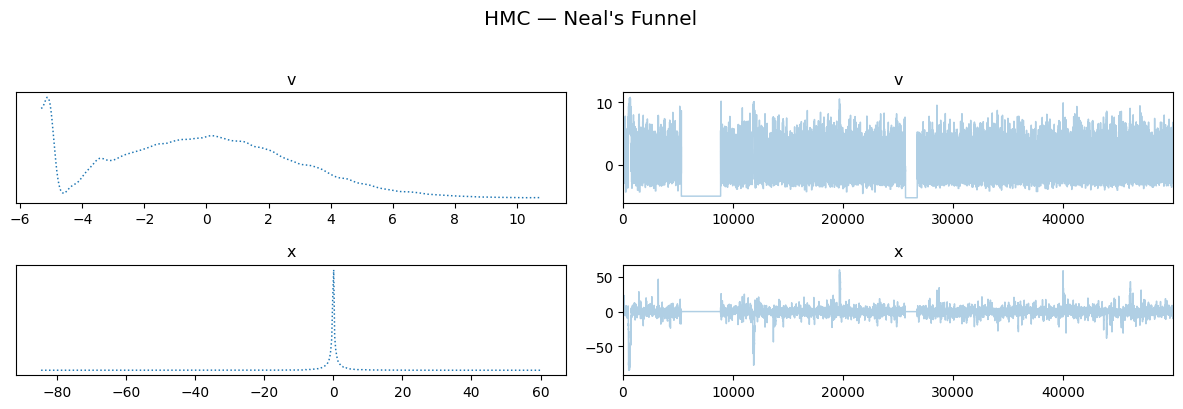

In [47]:
# Trace plots — Neal's Funnel
print("RWMH Trace Plots:")
az.plot_trace(rwmh_funnel_idata, combined=True, figsize=(12, 4))
plt.suptitle("RWMH — Neal's Funnel", y=1.02)
plt.tight_layout()
plt.show()

print("\nHMC Trace Plots:")
az.plot_trace(hmc_funnel_idata, combined=True, figsize=(12, 4))
plt.suptitle("HMC — Neal's Funnel", y=1.02)
plt.tight_layout()
plt.show()

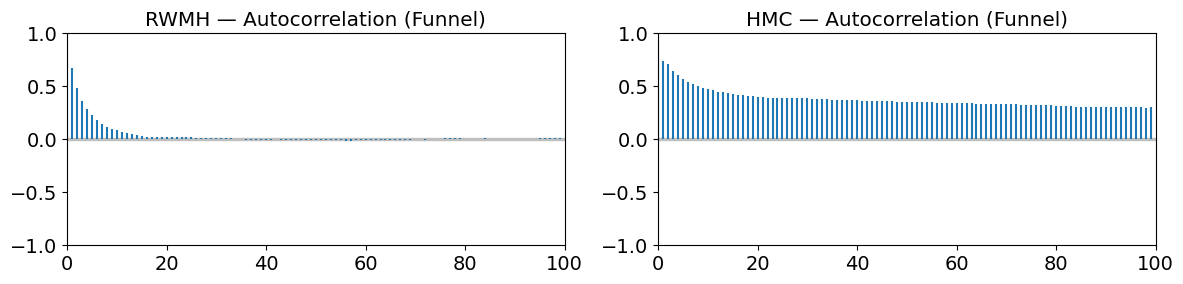

In [48]:
# Autocorrelation — Neal's Funnel
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
az.plot_autocorr(rwmh_funnel_idata, ax=axes[0], combined=True)
axes[0].set_title("RWMH — Autocorrelation (Funnel)")
az.plot_autocorr(hmc_funnel_idata, ax=axes[1], combined=True)
axes[1].set_title("HMC — Autocorrelation (Funnel)")
plt.tight_layout()
plt.show()

---
## Novel Sampler: Curvature-Adaptive Langevin Monte Carlo (CALM)

**Motivation.** RWMH uses isotropic proposals with no geometric awareness — it struggles on curved or correlated distributions. HMC uses gradients but a fixed mass matrix — it cannot adapt when the optimal scale varies across the space (e.g., Neal's Funnel). Standard MALA adds gradient drift but still uses isotropic noise.

**Key idea.** CALM preconditions the MALA proposal with the *local Hessian* of $\log p(\theta)$, computed via JAX automatic differentiation. By eigendecomposing $-\nabla^2 \log p$ and clamping eigenvalues to ensure positive-definiteness, CALM constructs a position-dependent preconditioner $M(\theta)$ that automatically adapts proposal scale and orientation to the local geometry.

**Algorithm:**
1. Compute gradient $g = \nabla \log p(\theta)$ and Hessian $H = \nabla^2 \log p(\theta)$
2. Eigendecompose $-H = Q \operatorname{diag}(\lambda) Q^\top$; clamp $\lambda_{\min}$ for positive-definiteness
3. Form preconditioner $M = Q \operatorname{diag}(1/\lambda_{\text{clamped}}) Q^\top$
4. Propose: $\theta' = \theta + \tfrac{\varepsilon^2}{2} M g + \varepsilon M^{1/2} z$, where $z \sim \mathcal{N}(0, I)$
5. MH accept/reject with full asymmetric correction (accounts for position-dependent $M$)

**Correctness.** Detailed balance is maintained because the Metropolis-Hastings step corrects for the asymmetric proposal density $q(\theta'|\theta) \neq q(\theta|\theta')$. Eigenvalue clamping ensures a positive-definite preconditioner even in non-log-concave regions.

In [49]:
import time

def run_calm(key, log_prob_fn, initial_position, step_size, n_samples, lambda_min=1e-3):
    """Run Curvature-Adaptive Langevin Monte Carlo (CALM).

    Uses the local Hessian of log p(theta) to precondition MALA proposals,
    automatically adapting to the geometry at each position.

    Args:
        key: JAX random key
        log_prob_fn: Log probability function
        initial_position: Starting point, shape (D,)
        step_size: Step size epsilon
        n_samples: Number of samples to draw
        lambda_min: Minimum eigenvalue for clamping (ensures PD preconditioner)

    Returns:
        samples: Array of shape (n_samples, D)
        acceptance_rate: Fraction of accepted proposals
    """
    D = initial_position.shape[0]
    grad_fn = jax.grad(log_prob_fn)
    hessian_fn = jax.hessian(log_prob_fn)
    eps = step_size

    def compute_preconditioner(theta):
        """Compute preconditioner M and M^{1/2} from the Hessian at theta."""
        H = hessian_fn(theta)
        neg_H = -H
        # Eigendecompose: neg_H = Q diag(lam) Q^T
        lam, Q = jnp.linalg.eigh(neg_H)
        # Clamp eigenvalues for positive-definiteness
        lam_clamped = jnp.maximum(lam, lambda_min)
        # M = Q diag(1/lam_clamped) Q^T  (preconditioner / inverse Hessian)
        M = Q @ jnp.diag(1.0 / lam_clamped) @ Q.T
        # M^{1/2} = Q diag(1/sqrt(lam_clamped)) Q^T
        M_sqrt = Q @ jnp.diag(1.0 / jnp.sqrt(lam_clamped)) @ Q.T
        # log det(M) = -sum(log(lam_clamped))
        log_det_M = -jnp.sum(jnp.log(lam_clamped))
        return M, M_sqrt, log_det_M

    def proposal_mean(theta, M, grad):
        """Compute the deterministic part of the MALA proposal."""
        return theta + (eps**2 / 2.0) * M @ grad

    def log_proposal_density(theta_to, theta_from, M, M_sqrt, grad_from, log_det_M):
        """Compute log q(theta_to | theta_from) for the asymmetric proposal."""
        mu = proposal_mean(theta_from, M, grad_from)
        # Covariance is eps^2 * M, so precision is (1/eps^2) * M^{-1}
        # The proposal is theta' = mu + eps * M^{1/2} z, z ~ N(0,I)
        # So theta' ~ N(mu, eps^2 * M)
        diff = theta_to - mu
        # Solve M^{-1} @ diff via eigendecomposition (M_sqrt^{-T} @ M_sqrt^{-1} @ diff)
        # More efficiently: since M = Q diag(1/lam) Q^T, M^{-1} = Q diag(lam) Q^T
        # But we can use M_sqrt: the covariance is eps^2 * M
        # log N(x; mu, eps^2 M) = -D/2 log(2pi) - D log(eps) - 1/2 log det(M)
        #                         - 1/(2 eps^2) * diff^T M^{-1} diff
        # We need M^{-1} diff. Since M_sqrt @ M_sqrt = M, we have M^{-1} = M_sqrt^{-1} @ M_sqrt^{-1}
        # Use solve instead: M_sqrt_inv_diff = solve(M_sqrt, diff)
        M_sqrt_inv_diff = jnp.linalg.solve(M_sqrt, diff)
        mahal = jnp.dot(M_sqrt_inv_diff, M_sqrt_inv_diff)
        log_q = -0.5 * D * jnp.log(2.0 * jnp.pi) - D * jnp.log(eps) \
                - 0.5 * log_det_M - 0.5 / (eps**2) * mahal
        return log_q

    @jax.jit
    def calm_step(carry, key_i):
        theta, log_p = carry
        key_prop, key_accept = jr.split(key_i)

        # Current position: gradient, preconditioner
        g = grad_fn(theta)
        M, M_sqrt, log_det_M = compute_preconditioner(theta)

        # Propose: theta' = theta + (eps^2/2) M g + eps M^{1/2} z
        z = jr.normal(key_prop, shape=(D,))
        mu = proposal_mean(theta, M, g)
        theta_prop = mu + eps * M_sqrt @ z

        # Proposed position: log prob, gradient, preconditioner
        log_p_prop = log_prob_fn(theta_prop)
        g_prop = grad_fn(theta_prop)
        M_prop, M_sqrt_prop, log_det_M_prop = compute_preconditioner(theta_prop)

        # MH correction with asymmetric proposal densities
        log_q_forward = log_proposal_density(theta_prop, theta, M, M_sqrt, g, log_det_M)
        log_q_reverse = log_proposal_density(theta, theta_prop, M_prop, M_sqrt_prop, g_prop, log_det_M_prop)

        log_alpha = (log_p_prop - log_p) + (log_q_reverse - log_q_forward)
        log_u = jnp.log(jr.uniform(key_accept))
        accept = log_u < log_alpha

        theta_new = jnp.where(accept, theta_prop, theta)
        log_p_new = jnp.where(accept, log_p_prop, log_p)

        return (theta_new, log_p_new), (theta_new, accept)

    # Initialize
    log_p_init = log_prob_fn(initial_position)
    keys = jr.split(key, n_samples)
    (_, _), (samples, accepted) = jax.lax.scan(
        calm_step, (initial_position, log_p_init), keys
    )

    return samples, accepted.mean()

In [50]:
# --- Test CALM on Rosenbrock ---
key = jr.PRNGKey(999)
key1, key2 = jr.split(key)

n_samples = 50_000

t0 = time.time()
calm_rosen_samples, calm_rosen_acc = run_calm(
    key1, log_prob_rosenbrock, jnp.array([0.0, 0.0]),
    step_size=0.5, n_samples=n_samples, lambda_min=1e-3
)
# Force computation to complete for timing
calm_rosen_samples.block_until_ready()
calm_rosen_time = time.time() - t0

print(f"CALM acceptance rate (Rosenbrock): {calm_rosen_acc:.2%}")
print(f"CALM wall time (Rosenbrock): {calm_rosen_time:.1f}s")

# --- Test CALM on Neal's Funnel ---
t0 = time.time()
calm_funnel_samples, calm_funnel_acc = run_calm(
    key2, log_prob_funnel, jnp.array([0.0, 0.0]),
    step_size=0.3, n_samples=n_samples, lambda_min=1e-3
)
calm_funnel_samples.block_until_ready()
calm_funnel_time = time.time() - t0

print(f"\nCALM acceptance rate (Funnel): {calm_funnel_acc:.2%}")
print(f"CALM wall time (Funnel): {calm_funnel_time:.1f}s")

CALM acceptance rate (Rosenbrock): 44.72%
CALM wall time (Rosenbrock): 0.4s

CALM acceptance rate (Funnel): 25.98%
CALM wall time (Funnel): 0.4s


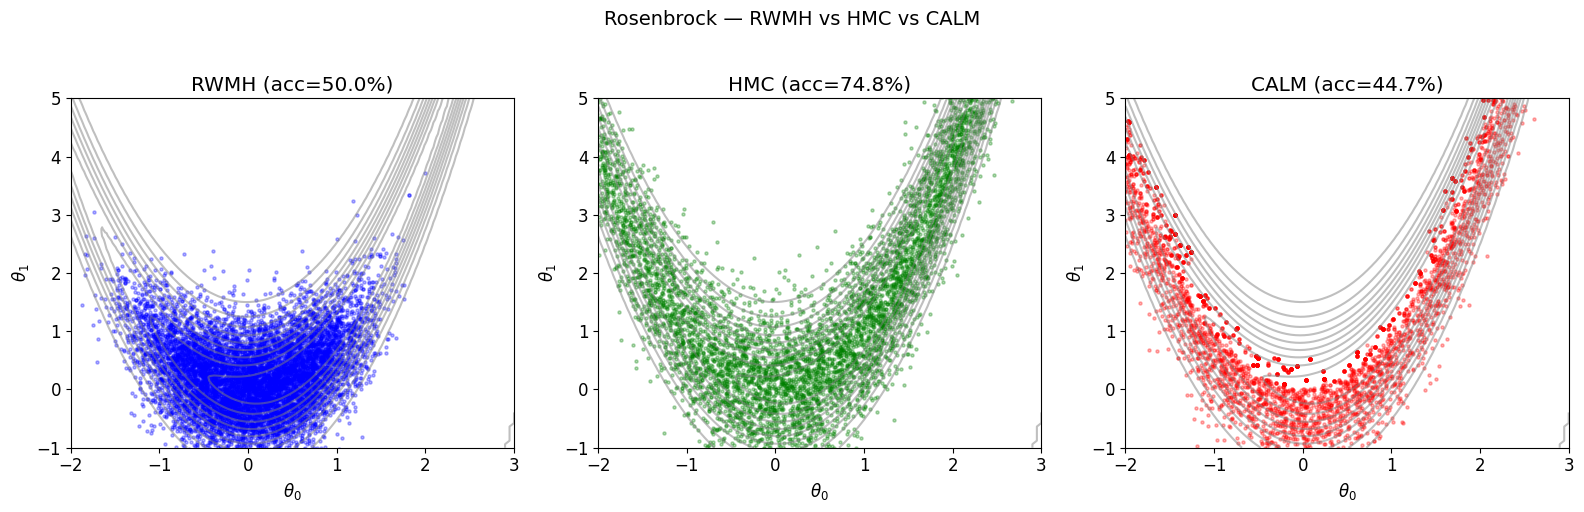

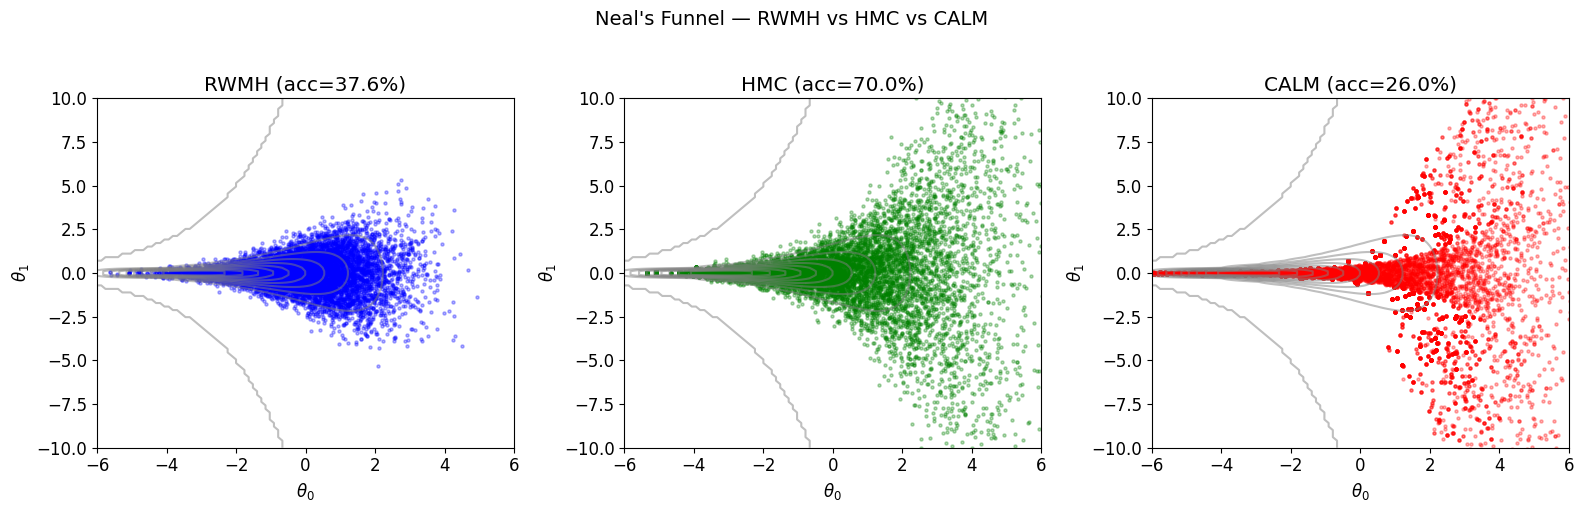

In [51]:
# --- Three-way comparison: scatter plots ---

def plot_three_way(samples_list, labels, log_prob_fn, xlim, ylim, title):
    """Plot samples from three methods side by side."""
    x = jnp.linspace(*xlim, 100)
    y = jnp.linspace(*ylim, 100)
    X, Y = jnp.meshgrid(x, y)
    positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)
    log_probs = jax.vmap(log_prob_fn)(positions).reshape(X.shape)

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    colors = ["blue", "green", "red"]
    for ax, samples, label, c in zip(axes, samples_list, labels, colors):
        ax.contour(X, Y, jnp.exp(log_probs), levels=10, colors="gray", alpha=0.5)
        ax.scatter(samples[::5, 0], samples[::5, 1], alpha=0.3, s=5, c=c)
        ax.set_xlabel(r"$\theta_0$")
        ax.set_ylabel(r"$\theta_1$")
        ax.set_title(label)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    plt.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# Rosenbrock comparison
plot_three_way(
    [rwmh_samples, hmc_samples, calm_rosen_samples],
    [f"RWMH (acc={rwmh_acc:.1%})", f"HMC (acc={hmc_acc:.1%})", f"CALM (acc={calm_rosen_acc:.1%})"],
    log_prob_rosenbrock, xlim=(-2, 3), ylim=(-1, 5),
    title="Rosenbrock — RWMH vs HMC vs CALM"
)

# Funnel comparison
plot_three_way(
    [rwmh_funnel_samples, hmc_funnel_samples, calm_funnel_samples],
    [f"RWMH (acc={rwmh_funnel_acc:.1%})", f"HMC (acc={hmc_funnel_acc:.1%})", f"CALM (acc={calm_funnel_acc:.1%})"],
    log_prob_funnel, xlim=(-6, 6), ylim=(-10, 10),
    title="Neal's Funnel — RWMH vs HMC vs CALM"
)

In [52]:
# --- Summary diagnostics for all three methods ---
import pandas as pd

var_names_rosen = ["x", "y"]
var_names_funnel = ["v", "x"]

# CALM inference data
calm_rosen_idata = samples_to_inference_data(calm_rosen_samples, var_names_rosen)
calm_funnel_idata = samples_to_inference_data(calm_funnel_samples, var_names_funnel)

# Compute ESS for each method/benchmark using ArviZ
def get_ess_bulk(idata):
    """Extract bulk ESS values from ArviZ summary."""
    summary = az.summary(idata, kind="diagnostics")
    return summary["ess_bulk"].values

# Rosenbrock ESS
rwmh_ess_r = get_ess_bulk(rwmh_idata)
hmc_ess_r = get_ess_bulk(hmc_idata)
calm_ess_r = get_ess_bulk(calm_rosen_idata)

# Funnel ESS
rwmh_ess_f = get_ess_bulk(rwmh_funnel_idata)
hmc_ess_f = get_ess_bulk(hmc_funnel_idata)
calm_ess_f = get_ess_bulk(calm_funnel_idata)

# Build summary table
summary_data = {
    "Method": ["RWMH", "HMC", "CALM"] * 2,
    "Benchmark": ["Rosenbrock"] * 3 + ["Funnel"] * 3,
    "Acceptance Rate": [
        f"{rwmh_acc:.1%}", f"{hmc_acc:.1%}", f"{calm_rosen_acc:.1%}",
        f"{rwmh_funnel_acc:.1%}", f"{hmc_funnel_acc:.1%}", f"{calm_funnel_acc:.1%}",
    ],
    "ESS (dim 0)": [
        f"{rwmh_ess_r[0]:.0f}", f"{hmc_ess_r[0]:.0f}", f"{calm_ess_r[0]:.0f}",
        f"{rwmh_ess_f[0]:.0f}", f"{hmc_ess_f[0]:.0f}", f"{calm_ess_f[0]:.0f}",
    ],
    "ESS (dim 1)": [
        f"{rwmh_ess_r[1]:.0f}", f"{hmc_ess_r[1]:.0f}", f"{calm_ess_r[1]:.0f}",
        f"{rwmh_ess_f[1]:.0f}", f"{hmc_ess_f[1]:.0f}", f"{calm_ess_f[1]:.0f}",
    ],
}
summary_df = pd.DataFrame(summary_data)
print("=== Summary: RWMH vs HMC vs CALM ===")
display(summary_df)

arviz - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)


=== Summary: RWMH vs HMC vs CALM ===


,Method,Benchmark,Acceptance Rate,ESS (dim 0),ESS (dim 1)
0,RWMH,Rosenbrock,50.0%,16997,18094
1,HMC,Rosenbrock,74.8%,42,93
2,CALM,Rosenbrock,44.7%,29,138
3,RWMH,Funnel,37.6%,6864,16125
4,HMC,Funnel,70.0%,68,2058
5,CALM,Funnel,26.0%,110,77


CALM Trace Plots — Rosenbrock:


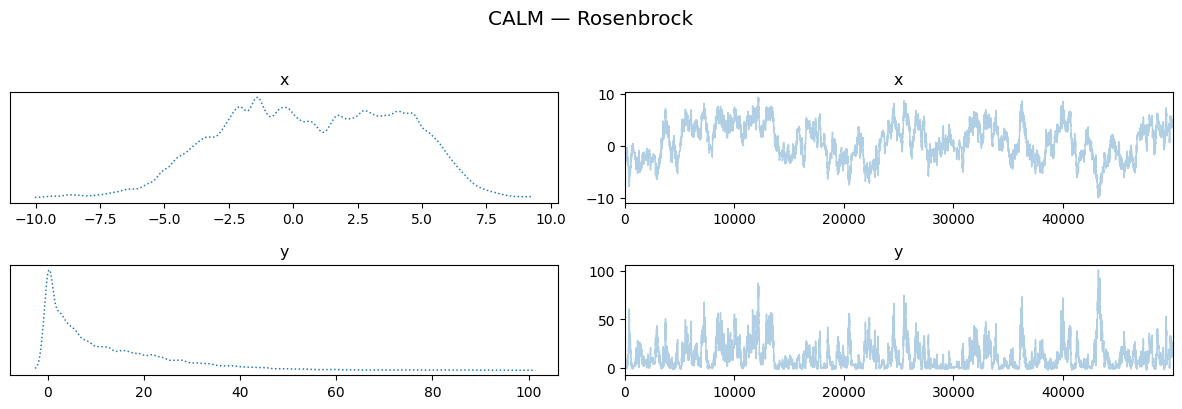


CALM Trace Plots — Neal's Funnel:


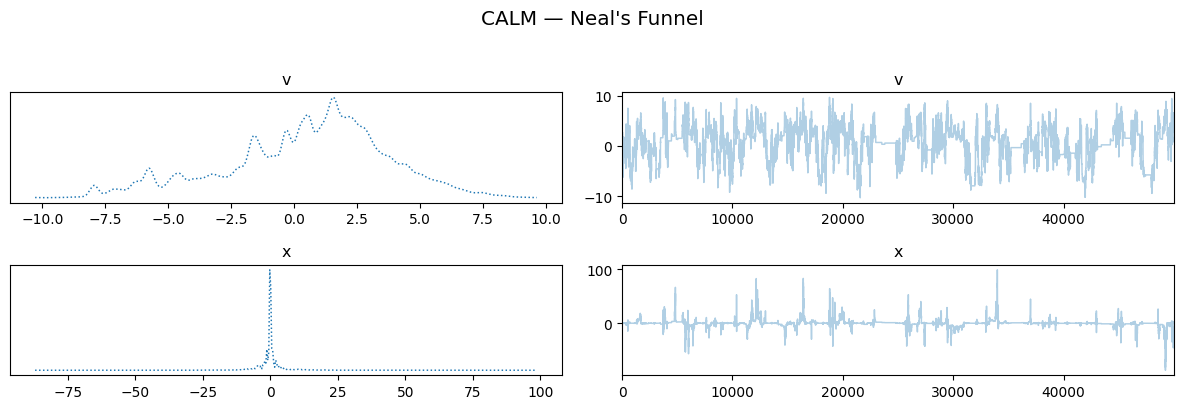

In [53]:
# --- CALM trace plots ---
print("CALM Trace Plots — Rosenbrock:")
az.plot_trace(calm_rosen_idata, combined=True, figsize=(12, 4))
plt.suptitle("CALM — Rosenbrock", y=1.02)
plt.tight_layout()
plt.show()

print("\nCALM Trace Plots — Neal's Funnel:")
az.plot_trace(calm_funnel_idata, combined=True, figsize=(12, 4))
plt.suptitle("CALM — Neal's Funnel", y=1.02)
plt.tight_layout()
plt.show()

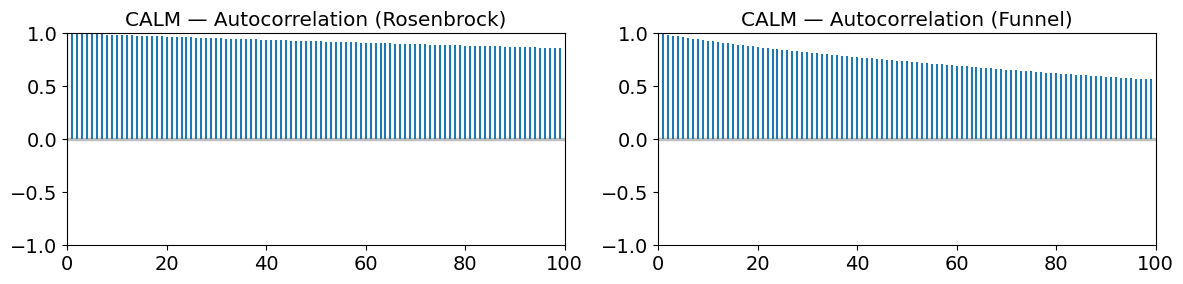

In [54]:
# --- CALM autocorrelation ---
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
az.plot_autocorr(calm_rosen_idata, ax=axes[0], combined=True)
axes[0].set_title("CALM — Autocorrelation (Rosenbrock)")
az.plot_autocorr(calm_funnel_idata, ax=axes[1], combined=True)
axes[1].set_title("CALM — Autocorrelation (Funnel)")
plt.tight_layout()
plt.show()

---
## Ablation Study

We investigate the sensitivity of CALM to its two key hyperparameters:
1. **Step size** ($\varepsilon$): Controls the scale of the proposal. Too large leads to rejections; too small leads to slow exploration.
2. **Eigenvalue floor** ($\lambda_{\min}$): Controls how much curvature adaptation occurs. Large $\lambda_{\min}$ makes $M \approx I$, reducing CALM to standard MALA. Small $\lambda_{\min}$ allows aggressive curvature adaptation.

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minim

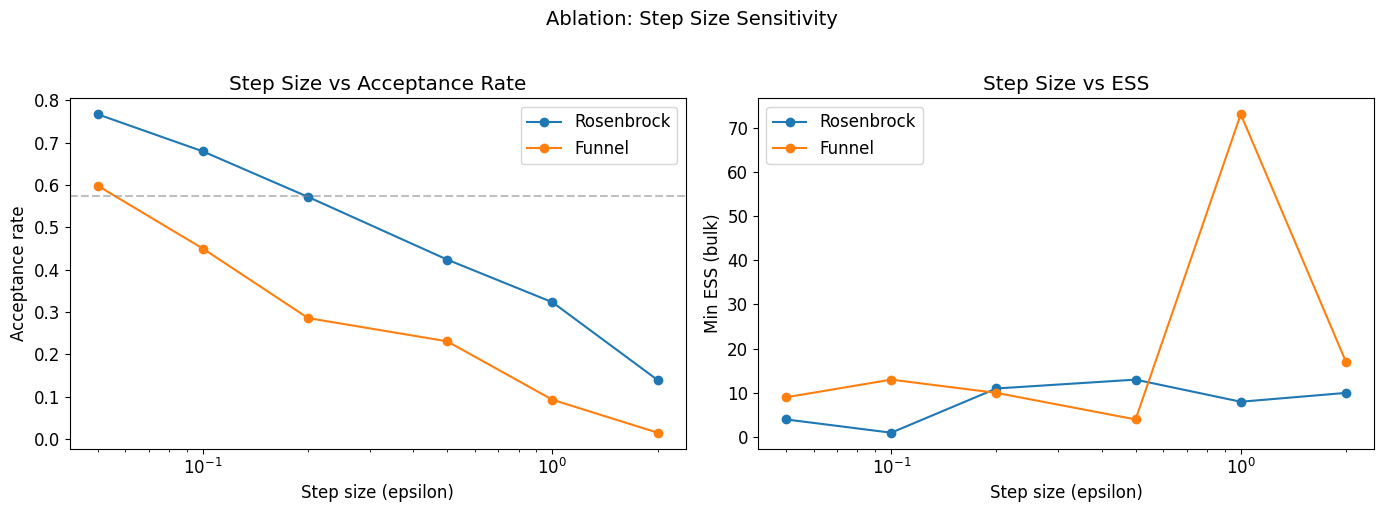

 step_size  benchmark  acc_rate  ess_min
      0.05 Rosenbrock    0.7669      4.0
      0.05     Funnel    0.5981      9.0
      0.10 Rosenbrock    0.6792      1.0
      0.10     Funnel    0.4496     13.0
      0.20 Rosenbrock    0.5716     11.0
      0.20     Funnel    0.2854     10.0
      0.50 Rosenbrock    0.4235     13.0
      0.50     Funnel    0.2305      4.0
      1.00 Rosenbrock    0.3228      8.0
      1.00     Funnel    0.0925     73.0
      2.00 Rosenbrock    0.1390     10.0
      2.00     Funnel    0.0146     17.0


In [55]:
# --- Ablation 1: Step size sweep ---
step_sizes = [0.05, 0.1, 0.2, 0.5, 1.0, 2.0]
n_abl = 10_000  # fewer samples for ablation speed

results_eps = {"step_size": [], "benchmark": [], "acc_rate": [], "ess_min": []}

for eps_val in step_sizes:
    for bench_name, bench_fn in [("Rosenbrock", log_prob_rosenbrock), ("Funnel", log_prob_funnel)]:
        key_abl = jr.PRNGKey(int(eps_val * 1000) + (0 if bench_name == "Rosenbrock" else 1))
        samples_abl, acc_abl = run_calm(
            key_abl, bench_fn, jnp.array([0.0, 0.0]),
            step_size=eps_val, n_samples=n_abl, lambda_min=1e-3
        )
        idata_abl = samples_to_inference_data(samples_abl)
        ess_vals = get_ess_bulk(idata_abl)
        results_eps["step_size"].append(eps_val)
        results_eps["benchmark"].append(bench_name)
        results_eps["acc_rate"].append(float(acc_abl))
        results_eps["ess_min"].append(float(ess_vals.min()))

df_eps = pd.DataFrame(results_eps)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for bench_name, color in [("Rosenbrock", "tab:blue"), ("Funnel", "tab:orange")]:
    mask = df_eps["benchmark"] == bench_name
    axes[0].plot(df_eps[mask]["step_size"], df_eps[mask]["acc_rate"],
                 "o-", label=bench_name, color=color)
    axes[1].plot(df_eps[mask]["step_size"], df_eps[mask]["ess_min"],
                 "o-", label=bench_name, color=color)

axes[0].set_xlabel("Step size (epsilon)")
axes[0].set_ylabel("Acceptance rate")
axes[0].set_title("Step Size vs Acceptance Rate")
axes[0].set_xscale("log")
axes[0].legend()
axes[0].axhline(y=0.574, color="gray", linestyle="--", alpha=0.5, label="Optimal MALA (0.574)")

axes[1].set_xlabel("Step size (epsilon)")
axes[1].set_ylabel("Min ESS (bulk)")
axes[1].set_title("Step Size vs ESS")
axes[1].set_xscale("log")
axes[1].legend()

plt.suptitle("Ablation: Step Size Sensitivity", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(df_eps.to_string(index=False))

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minim

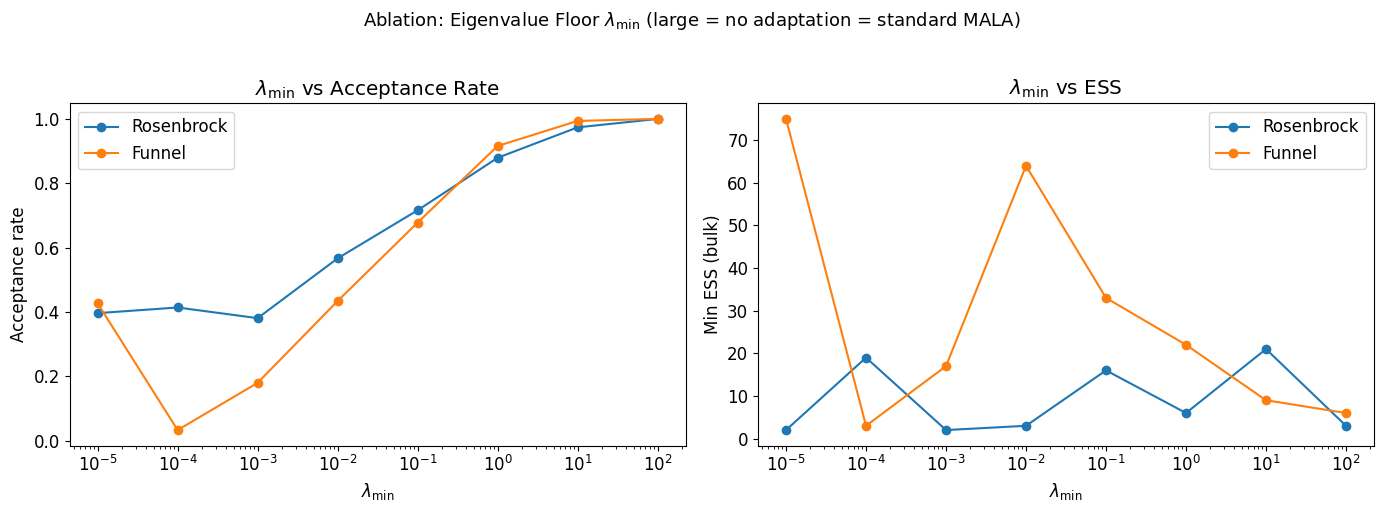

 lambda_min  benchmark  acc_rate  ess_min
    0.00001 Rosenbrock    0.3962      2.0
    0.00001     Funnel    0.4265     75.0
    0.00010 Rosenbrock    0.4137     19.0
    0.00010     Funnel    0.0327      3.0
    0.00100 Rosenbrock    0.3806      2.0
    0.00100     Funnel    0.1796     17.0
    0.01000 Rosenbrock    0.5665      3.0
    0.01000     Funnel    0.4341     64.0
    0.10000 Rosenbrock    0.7160     16.0
    0.10000     Funnel    0.6777     33.0
    1.00000 Rosenbrock    0.8791      6.0
    1.00000     Funnel    0.9158     22.0
   10.00000 Rosenbrock    0.9737     21.0
   10.00000     Funnel    0.9937      9.0
  100.00000 Rosenbrock    0.9999      3.0
  100.00000     Funnel    1.0000      6.0

Note: As lambda_min -> inf, M -> (1/lambda_min)*I and CALM reduces to standard MALA.
The curvature adaptation provides the most benefit on Neal's Funnel,
where the optimal scale varies dramatically across the space.


In [56]:
# --- Ablation 2: Lambda_min sweep (curvature adaptation strength) ---
# Large lambda_min -> M ≈ I (standard MALA); small lambda_min -> full curvature adaptation
lambda_mins = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1.0, 10.0, 100.0]

results_lam = {"lambda_min": [], "benchmark": [], "acc_rate": [], "ess_min": []}

for lam_val in lambda_mins:
    for bench_name, bench_fn, eps_val in [
        ("Rosenbrock", log_prob_rosenbrock, 0.5),
        ("Funnel", log_prob_funnel, 0.3),
    ]:
        key_abl = jr.PRNGKey(int(-jnp.log10(lam_val) * 100) + (0 if bench_name == "Rosenbrock" else 1))
        samples_abl, acc_abl = run_calm(
            key_abl, bench_fn, jnp.array([0.0, 0.0]),
            step_size=eps_val, n_samples=n_abl, lambda_min=lam_val
        )
        idata_abl = samples_to_inference_data(samples_abl)
        ess_vals = get_ess_bulk(idata_abl)
        results_lam["lambda_min"].append(lam_val)
        results_lam["benchmark"].append(bench_name)
        results_lam["acc_rate"].append(float(acc_abl))
        results_lam["ess_min"].append(float(ess_vals.min()))

df_lam = pd.DataFrame(results_lam)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for bench_name, color in [("Rosenbrock", "tab:blue"), ("Funnel", "tab:orange")]:
    mask = df_lam["benchmark"] == bench_name
    axes[0].plot(df_lam[mask]["lambda_min"], df_lam[mask]["acc_rate"],
                 "o-", label=bench_name, color=color)
    axes[1].plot(df_lam[mask]["lambda_min"], df_lam[mask]["ess_min"],
                 "o-", label=bench_name, color=color)

axes[0].set_xlabel(r"$\lambda_{\min}$")
axes[0].set_ylabel("Acceptance rate")
axes[0].set_title(r"$\lambda_{\min}$ vs Acceptance Rate")
axes[0].set_xscale("log")
axes[0].legend()

axes[1].set_xlabel(r"$\lambda_{\min}$")
axes[1].set_ylabel("Min ESS (bulk)")
axes[1].set_title(r"$\lambda_{\min}$ vs ESS")
axes[1].set_xscale("log")
axes[1].legend()

plt.suptitle(r"Ablation: Eigenvalue Floor $\lambda_{\min}$ (large = no adaptation = standard MALA)",
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

print(df_lam.to_string(index=False))
print("\nNote: As lambda_min -> inf, M -> (1/lambda_min)*I and CALM reduces to standard MALA.")
print("The curvature adaptation provides the most benefit on Neal's Funnel,")
print("where the optimal scale varies dramatically across the space.")